<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/Reproject_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rioxarray rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 34.9 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=feae0311fb0646fe22bd4a241a2db45ffc8d4ab16896c1b4f2fb674968bf7f94
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


# Reprojection in rasterio 

#TODO understand this code in detail later

In [13]:
from rasterio import transform
with rasterio.Env():

    # Consider a 512 x 512 raster centered on 0 degrees E and 0 degrees N
    # with each pixel covering 15".
    rows, cols = src_shape = (8, 8)
    dpp = 1.0/240  # decimal degrees per pixel
    west, south, east, north = -cols*dpp/2, -rows*dpp/2, cols*dpp/2, rows*dpp/2
    src_transform = transform.from_bounds(west, south, east, north, cols, rows)
    src_crs = {'init': 'EPSG:4326'}
    source = np.ones(src_shape, np.uint8)*255

    # Prepare to reproject this rasters to a 1024 x 1024 dataset in
    # Web Mercator (EPSG:3857) with origin at -237481.5, 237536.4.
    dst_shape = (16, 16)
    dst_transform = transform.from_origin(-237481.5, 237536.4, 425.0, 425.0)
    dst_crs = {'init': 'EPSG:3857'}
    destination = np.zeros(dst_shape, np.uint8)

    reproject(
        source,
        destination,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)

    # Assert that the destination is only partly filled.
    assert destination.any()
    assert not destination.all()

AssertionError: ignored

# rioxarray

In [2]:
import rioxarray


In [3]:
# Why does masked=True convert the data type into float32,
# something wrong with documentation - it says float64 instead of float32
# https://corteva.github.io/rioxarray/stable/examples/resampling.html
xds = rioxarray.open_rasterio('/content/drive/MyDrive/nrcan/lc_data/aoi_512x512/aoi4_lc_021')

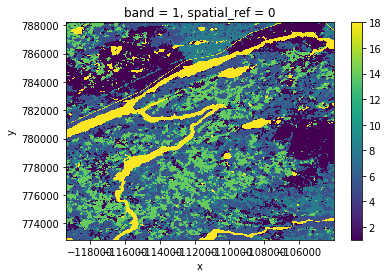

In [4]:
xds.plot()

In [18]:
xds.values

array([[[ 1, 18, 18, ...,  8,  8,  8],
        [ 1,  1, 18, ...,  8,  8,  8],
        [ 1,  1,  1, ...,  8,  8,  8],
        ...,
        [ 5,  5, 18, ..., 14, 14, 14],
        [18, 18, 18, ..., 14, 14, 14],
        [18, 18, 18, ...,  8, 14,  5]]], dtype=uint8)

In [6]:
??xds.to_dataframe()

In [17]:
??xds.squeeze


In [19]:
from xarray.core.common import get_squeeze_dims
get_squeeze_dims(xds)

['band']

In [22]:
xds.squeeze()

<xarray.DataArray (y: 512, x: 512)>
array([[ 1, 18, 18, ...,  8,  8,  8],
       [ 1,  1, 18, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  8,  8,  8],
       ...,
       [ 5,  5, 18, ..., 14, 14, 14],
       [18, 18, 18, ..., 14, 14, 14],
       [18, 18, 18, ...,  8, 14,  5]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 -1.194e+05 -1.193e+05 ... -1.041e+05 -1.04e+05
  * y            (y) float64 7.882e+05 7.882e+05 ... 7.729e+05 7.729e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0

In [33]:
import numpy as np
import xarray as xr
data = np.arange(6).reshape(2, 3)

labels = ["a", "b", "c"]

ds = xr.Dataset({"A": (["x", "y"], data), "y": labels, "x": ['xa', 'xb']})

ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * y        (y) <U1 'a' 'b' 'c'
  * x        (x) <U2 'xa' 'xb'
Data variables:
    A        (x, y) int64 0 1 2 3 4 5

In [46]:
#xds.drop_dims('spatial_ref')
xds = xds.rename('landcover_type')
print(xds)


<xarray.DataArray 'landcover_type' (band: 1, y: 512, x: 512)>
array([[[ 1, 18, ...,  8,  8],
        [ 1,  1, ...,  8,  8],
        ...,
        [18, 18, ..., 14, 14],
        [18, 18, ..., 14,  5]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.194e+05 -1.193e+05 ... -1.041e+05 -1.04e+05
  * y            (y) float64 7.882e+05 7.882e+05 ... 7.729e+05 7.729e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0


<xarray.Dataset>
Dimensions:         (band: 1, x: 512, y: 512)
Coordinates:
  * band            (band) int64 1
  * x               (x) float64 -1.194e+05 -1.193e+05 ... -1.041e+05 -1.04e+05
  * y               (y) float64 7.882e+05 7.882e+05 ... 7.729e+05 7.729e+05
Data variables:
    spatial_ref     int64 0
    landcover_type  (band, y, x) uint8 1 18 18 18 6 6 8 8 6 ... 8 8 8 8 8 8 14 5

In [47]:
xds = xds.reset_coords('spatial_ref', drop=True)
lc_pd = xds.squeeze(drop=True).to_dataframe(name="lc_types", dim_order=['x', 'y'])
lc_pd


lc_types
x              y                      
-119355.270118 788190.289478         1
               788160.289478         1
               788130.289478         1
               788100.289478         1
               788070.289478         1
...                                ...
-104025.270118 772980.289478         8
               772950.289478         8
               772920.289478        14
               772890.289478        14
               772860.289478         5

[262144 rows x 1 columns]

In [6]:
xds.rio.resolution()

(30.0, -30.0)

In [7]:
xds.rio.crs

CRS.from_epsg(3978)

In [9]:
xds.rio.estimate_utm_crs()

CRS.from_epsg(32614)

In [79]:
??xarray.open_dataset

In [57]:
import xarray
sentinel = xarray.open_dataset('/content/drive/MyDrive/nrcan/sentinel_aoi_images/aoi4_lc_021/202008.tif',
                               engine="rasterio")
# sentinel = rioxarray.open_rasterio('/content/drive/MyDrive/nrcan/sentinel_aoi_images/aoi4_lc_021/202008.tif')

In [58]:
sentinel.rio.crs

CRS.from_epsg(32614)

In [59]:
sentinel.rio.estimate_utm_crs()

CRS.from_epsg(32614)

In [60]:
# get the transform
sentinel.rio.resolution()

(10.0, -10.0)

In [61]:
sentinel.rio.transform()

Affine(10.0, 0.0, 626510.0,
       0.0, -10.0, 6225720.0)

In [62]:
sentinel

<xarray.Dataset>
Dimensions:      (band: 12, x: 1662, y: 1662)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [63]:
sentinel = sentinel.reset_coords('spatial_ref', drop=True)

In [64]:
sentinel

<xarray.Dataset>
Dimensions:    (band: 12, x: 1662, y: 1662)
Coordinates:
  * band       (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x          (x) float64 6.265e+05 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y          (y) float64 6.226e+06 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
Data variables:
    band_data  (band, y, x) float32 ...

In [69]:
sentinel.data_vars

Data variables:
    band_data  (band, y, x) float32 0.0209 0.0199 0.0199 ... 0.0788 0.0809

In [66]:
sentinel.indexes

band: Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='band')
x: Float64Index([626515.0, 626525.0, 626535.0, 626545.0, 626555.0, 626565.0,
                 626575.0, 626585.0, 626595.0, 626605.0,
                 ...
                 643035.0, 643045.0, 643055.0, 643065.0, 643075.0, 643085.0,
                 643095.0, 643105.0, 643115.0, 643125.0],
                dtype='float64', name='x', length=1662)
y: Float64Index([6225715.0, 6225705.0, 6225695.0, 6225685.0, 6225675.0, 6225665.0,
                 6225655.0, 6225645.0, 6225635.0, 6225625.0,
                 ...
                 6209195.0, 6209185.0, 6209175.0, 6209165.0, 6209155.0, 6209145.0,
                 6209135.0, 6209125.0, 6209115.0, 6209105.0],
                dtype='float64', name='y', length=1662)

In [67]:
sentinel.to_dataframe()

band_data
band x        y                   
1    626515.0 6225715.0     0.0209
              6225705.0     0.0209
              6225695.0     0.0209
              6225685.0     0.0209
              6225675.0     0.0209
...                            ...
12   643125.0 6209145.0     0.0778
              6209135.0     0.0775
              6209125.0     0.0775
              6209115.0     0.0809
              6209105.0     0.0809

[33146928 rows x 1 columns]

# Reproject land cover to UTM
- see if the bounds match sentinel images

In [60]:
from rasterio.enums import Resampling
upscale_factor = 3
new_width = xds.rio.width * upscale_factor
new_height = xds.rio.height * upscale_factor
xds_utm = xds.rio.reproject(xds.rio.estimate_utm_crs(),
                            shape=(new_height, new_width),
                            resampling=Resampling.nearest)

In [61]:
def print_xda_info(xda):
  xda_nodata = (xda == xda.rio.nodata)
  print(
      f"crs: {xda.rio.crs}\n"
      f"transform: {xda.rio.transform()}\n"
      f"shape: {xda.rio.shape}\n"
      f"resolution: {xda.rio.resolution()}\n"
      f"bounds: {xda.rio.bounds()}\n"
      f"sum: {xda.sum().item()},\n"
      f"nodata count: {xda_nodata.sum().item()}\n"
  )


In [62]:
print_xda_info(xds)
print_xda_info(xds_utm)
print_xda_info(sentinel)

crs: EPSG:3978
transform: | 30.00, 0.00,-119370.27|
| 0.00,-30.00, 788205.29|
| 0.00, 0.00, 1.00|
shape: (512, 512)
resolution: (30.0, -30.0)
bounds: (-119370.2701179129, 772845.2894780128, -104010.2701179129, 788205.2894780128)
sum: 1959304,
nodata count: 0

crs: EPSG:32614
transform: | 10.82, 0.00, 626514.92|
| 0.00,-10.82, 6225711.90|
| 0.00, 0.00, 1.00|
shape: (1536, 1536)
resolution: (10.81571746608957, -10.81571746608957)
bounds: (626514.9160368822, 6209098.960413956, 643127.8580647958, 6225711.9024418695)
sum: 80491942,
nodata count: 253947

crs: EPSG:32614
transform: | 10.00, 0.00, 626510.00|
| 0.00,-10.00, 6225720.00|
| 0.00, 0.00, 1.00|
shape: (1662, 1662)
resolution: (10.0, -10.0)
bounds: (626510.0, 6209100.0, 643130.0, 6225720.0)
sum: 3829484.75,
nodata count: 0



# Reproject by matching


In [122]:
??xds.rio.reproject

In [132]:
lc_xda = xds.rio.reproject(sentinel.rio.crs, resolution=(10,10), resampling=Resampling.nearest, nodata=0.0)
# lc_xda = lc_xda.assign_coords({
#     "x": sentinel.x,
#     "y": sentinel.y
# })
print_xda_info(lc_xda)

crs: EPSG:32614
transform: | 10.00, 0.00, 626514.92|
| 0.00,-10.00, 6225711.90|
| 0.00, 0.00, 1.00|
shape: (1662, 1662)
resolution: (10.0, -10.0)
bounds: (626514.9160368822, 6209091.9024418695, 643134.9160368822, 6225711.9024418695)
sum: 18408196,
nodata count: 0



In [136]:
lc_xda.x

<xarray.DataArray 'x' (x: 1662)>
array([626519.916037, 626529.916037, 626539.916037, ..., 643109.916037,
       643119.916037, 643129.916037])
Coordinates:
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre

In [138]:
sentinel.y

<xarray.DataArray 'y' (y: 1662)>
array([6225715., 6225705., 6225695., ..., 6209125., 6209115., 6209105.])
Coordinates:
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
    spatial_ref  int64 0

In [140]:
lc_xda.x.attrs

{'axis': 'X',
 'long_name': 'x coordinate of projection',
 'standard_name': 'projection_x_coordinate',
 'units': 'metre'}

In [142]:
xds.attrs

{'_FillValue': 255.0, 'add_offset': 0.0, 'scale_factor': 1.0}

In [133]:
import numpy as np
y_sum = (sentinel.x - lc_xda.x)
np.abs(y_sum.values).max()

ValueError: ignored

In [71]:
xds

<xarray.DataArray (band: 1, y: 512, x: 512)>
array([[[ 1, 18, ...,  8,  8],
        [ 1,  1, ...,  8,  8],
        ...,
        [18, 18, ..., 14, 14],
        [18, 18, ..., 14,  5]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.194e+05 -1.193e+05 ... -1.041e+05 -1.04e+05
  * y            (y) float64 7.882e+05 7.882e+05 ... 7.729e+05 7.729e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0

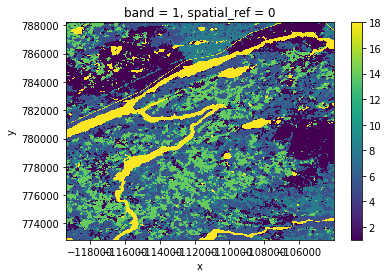

In [72]:
xds.plot()

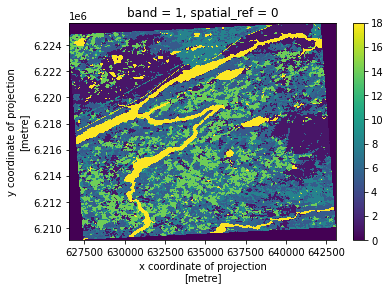

In [127]:
lc_xda.plot()

In [128]:
lc_xda

<xarray.DataArray (band: 1, y: 1662, x: 1662)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

AttributeError: ignored

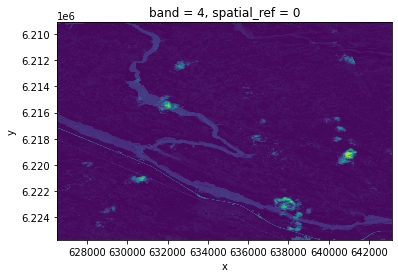

In [117]:

%matplotlib inline
sentinel.sel(band=4).plot()

In [68]:
lc_xda

<xarray.DataArray (band: 1, y: 1662, x: 1662)>
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

# Merge LC and Sentinel Rasters

In [42]:
np.unique(xds.values, return_counts=True)

(array([ 1.,  2.,  5.,  6.,  8., 10., 14., 16., 17., 18.], dtype=float32),
 array([62457,    49, 45319, 34903, 49241,  1788, 45313,    42,   702,
        22330]))

In [129]:
np.unique(lc_xda.values, return_counts=True)

(array([ 0,  1,  2,  5,  6,  8, 10, 14, 16, 17, 18], dtype=uint8),
 array([299406, 586637,    453, 425832, 328039, 462621,  16809, 425616,
           392,   6597, 209842]))

In [53]:
lc_xda.attrs

{'add_offset': 0.0, 'scale_factor': 1.0}

In [55]:
import sys
np.set_printoptions(threshold=20)
lc_xda.values[0][10]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [27]:
from xarray import concat

xconcat = concat([sentinel, lc_xda], dim="band")
xconcat

<xarray.DataArray (band: 13, y: 1662, x: 1662)>
array([[[0.0209, 0.0199, 0.0199, ..., 0.0203, 0.0203, 0.0203],
        [0.0209, 0.0199, 0.0199, ..., 0.0203, 0.0203, 0.0203],
        [0.0209, 0.0199, 0.0199, ..., 0.0203, 0.0203, 0.0203],
        ...,
        [0.0432, 0.0462, 0.0462, ..., 0.024 , 0.024 , 0.024 ],
        [0.0432, 0.0462, 0.0462, ..., 0.024 , 0.024 , 0.024 ],
        [0.0432, 0.0462, 0.0462, ..., 0.024 , 0.024 , 0.024 ]],

       [[0.0231, 0.0266, 0.0276, ..., 0.0284, 0.0296, 0.0263],
        [0.0222, 0.0246, 0.0243, ..., 0.0302, 0.0299, 0.0274],
        [0.0232, 0.021 , 0.0232, ..., 0.0311, 0.0328, 0.0275],
        ...,
        [0.0583, 0.0602, 0.0594, ..., 0.0264, 0.0314, 0.0289],
        [0.055 , 0.06  , 0.0563, ..., 0.0266, 0.0271, 0.0314],
        [0.0562, 0.0572, 0.0558, ..., 0.0257, 0.0249, 0.0271]],

       [[0.0414, 0.0485, 0.0502, ..., 0.0478, 0.051 , 0.042 ],
        [0.0373, 0.0431, 0.0425, ..., 0.0494, 0.0524, 0.0459],
        [0.0405, 0.0411, 0.0399, ..., 0.0531, 0.0579, 0.0507],
        ...,
...
        [0.0132, 0.0138, 0.0138, ..., 0.1647, 0.1647, 0.1533],
        [0.0108, 0.0114, 0.0114, ..., 0.1638, 0.1638, 0.1606],
        [0.0108, 0.0114, 0.0114, ..., 0.1638, 0.1638, 0.1606]],

       [[0.0634, 0.0695, 0.0695, ..., 0.0637, 0.0637, 0.0605],
        [0.0634, 0.0695, 0.0695, ..., 0.0637, 0.0637, 0.0605],
        [0.0576, 0.0582, 0.0582, ..., 0.0697, 0.0697, 0.0686],
        ...,
        [0.0102, 0.0119, 0.0119, ..., 0.0809, 0.0809, 0.0775],
        [0.0074, 0.0079, 0.0079, ..., 0.0788, 0.0788, 0.0809],
        [0.0074, 0.0079, 0.0079, ..., 0.0788, 0.0788, 0.0809]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 1
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1_max', 'B2_max', 'B3_max', 'B4_max', 'B5_max', 'B6_max...

# Convert to Pandas Data Frame


# Check for missing values

In [55]:
xds_nodata = (xds == xds.rio.nodata)
xds_nodata

<xarray.DataArray (band: 1, y: 512, x: 512)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.194e+05 -1.193e+05 ... -1.041e+05 -1.04e+05
  * y            (y) float64 7.882e+05 7.882e+05 ... 7.729e+05 7.729e+05
    spatial_ref  int64 0

In [58]:
xds.any().item()

True

In [61]:
xds_nodata.sum().item()

0